In [1]:
#02/03/2020 TO DO:

# - Create a set grid of electrodes using Network['length_x'] + Network['length_y']
# -- Find the closest Network['xa,ya'] and Network['xb,yb'] points to each elctrode and set that as source or drain.

In [2]:
import sys
sys.path.append('/import/silo2/aloe8475/Documents/edamame')

In [205]:
from scipy.io import loadmat, savemat
from scipy import signal
from edamame import * 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import networkx as nx
from tqdm import tqdm_notebook as tqdm
import os
from IPython.core.debugger import set_trace


# ASSOCIATIVE LEARNING 

In [4]:
#Generate Network
this_seed=8637#np.random.randint(10000)
Network=edamame.core.generate_network(300,this_seed=this_seed)

2021-04-15 12:11:19,581:INFO:Detecting junctions
2021-04-15 12:11:20,999:INFO:Finished detecting junctions
2021-04-15 12:11:21,042:INFO:The returned network has 5114 junctions.


In [5]:
connectivity=connectivity__(wires_dict=Network)

In [441]:
#Initialise Training + Testing:
numSessions=2
numTraining = 5 #how many training simulations to run per session
numTesting = 1

#Testing and Training patterns: 
# 9 drains, 3 sources
b_testing=np.array([194, 230, 79, 34, 127, 169, 133, 264, 91,117]) #272,117, 148])#edamame.core.getBoundaryPairing(connectivity,9)
b_training=b_testing[:]

pattern_type=4 # CHANGE PATTERN HERE

# Open Electrodes for training 
if pattern_type == 1:
    training_list=[0,2,4,9,10,11] #drains, then sources
elif pattern_type == 2:
    training_list=[4,7,8,9,10,11] #drains, then sources
elif pattern_type == 3:
    training_list=[0,4,7,8,9,10,11] #drains, then sources
elif pattern_type == 4:
    training_list=[2,4,6,8,9]#,10,11] #drains, then sources
    
num_source_training=1
num_drain_training=len(training_list)-num_source_training
# Open Electrodes for testing

# testing_list=[0,1,2,3,4,5,6,7,8,9,11,13]#Drains then sources 
testing_list=[0,1,2,3,4,5,6,7,8,9]#,10,11]#Drains then sources

num_source_testing=num_source_training
num_drain_testing=len(testing_list)-num_source_testing

b_testing=b_testing[testing_list]
b_training=b_training[training_list]


#initialise stimulus:

onAmp_training = 1 #amplitude for training
onAmp_testing=0.2 #amplitude for testing
signal_time = 0.5
rest_time = 0.5
rest_between_training=30
run_time=signal_time+rest_time

dt = 0.001
f= 1

training_stimulus = []
testing_stimulus = []
resting_stimulus=[]
training_sims=[None]*numTraining
testing_sims=[None]*numTesting
resting_sims=[None]*(numSessions-1) #rest between sessions

#TRAINING STIMULUS
# ONLY DRAINS WITH CORRESPONDING STIMULUS SOURCE ARE ACTIVE
#Drains: 
for i in range(num_drain_training):
    #DRAIN WITHOUT REST
    training_stimulus.append((stimulus__(biasType='Drain',TimeVector=np.arange(0,run_time,dt))))
    resting_stimulus.append((stimulus__(biasType='Drain',TimeVector=np.arange(0,rest_between_training,dt))))
    #Can we do reinforcement training by changing amplitude of drains that we don't want involved?

#Sources
for i in range(num_source_training):
    #SOURCE WITHOUT REST
    training_stimulus.append((stimulus__(biasType='DC',onAmp=onAmp_training,TimeVector=np.arange(0,signal_time,dt),f=f)))
    
    #ADD REST AT THE END
    training_stimulus[(num_drain_training)+i].signal=np.concatenate([np.array(stimulus__(biasType='DC',onAmp=onAmp_training,TimeVector=np.arange(0,signal_time,dt),f=f).signal), np.array([0.005]*int(rest_time/dt))]) 
    
    #REST BETWEEN SESSIONS
    resting_stimulus.append((stimulus__(biasType='DC',onAmp=0.0001,TimeVector=np.arange(0,rest_between_training,dt),f=f)))

    
#CONVERT TO BOOLEAN FOR TARGET PATTERN:

if pattern_type == 1:
    boolTargets=np.array([onAmp_training,0,onAmp_training,0,onAmp_training,0,0,0,0]).astype(bool)

elif pattern_type == 2:
    boolTargets=np.array([0,0,0,0,onAmp_training,0,0,onAmp_training,onAmp_training]).astype(bool)

elif pattern_type == 3:
    boolTargets=np.array([onAmp_training,0,0,0,onAmp_training,0,0,onAmp_training,onAmp_training]).astype(bool)
elif pattern_type==4:
    boolTargets=np.array([0,0,onAmp_training,0,onAmp_training,0,onAmp_training,0,onAmp_training]).astype(bool)

drainAndSourceTargets=np.hstack((boolTargets,np.zeros(num_source_training).astype(bool)))

In [411]:
# #Change non active drains to negative voltage
# for i in range(num_drain_testing):
#     if i in training_list[:num_drain_training]:
#     #DRAIN WITHOUT REST
#         training_stimulus[count]=((stimulus__(biasType='Drain',TimeVector=np.arange(0,run_time,dt))))
#         resting_stimulus[count]=((stimulus__(biasType='Drain',TimeVector=np.arange(0,rest_between_training,dt))))
#     #Can we do reinforcement training by changing amplitude of drains that we don't want involved?
#     else:
#         training_stimulus[count]=((stimulus__(biasType='DC',onAmp=-0.05,TimeVector=np.arange(0,run_time,dt))))
#         training_stimulus[count].signal=np.concatenate([np.array(stimulus__(biasType='DC',onAmp=-0.05,TimeVector=np.arange(0,signal_time,dt),f=f).signal), np.array([0]*int(rest_time/dt))]) 
#         resting_stimulus[count]=((stimulus__(biasType='Drain',TimeVector=np.arange(0,rest_between_training,dt))))
#     count=count+1

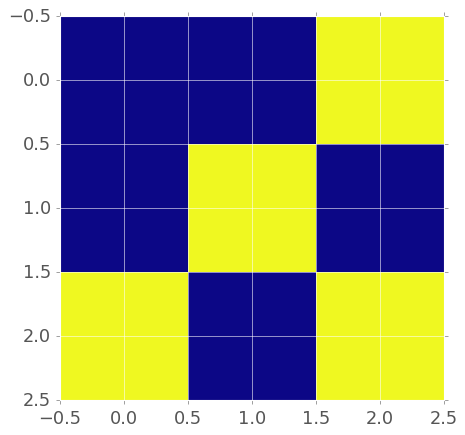

In [443]:
#Show target
plt.imshow((boolTargets.reshape(3,3)).astype(int),interpolation='none',cmap='plasma')

In [444]:
b_training

array([ 79, 127, 133,  91, 117])

In [445]:
#Run Training
training_state=[None]*numTraining #system state for training
testing_state=[None]*numTesting #system state for testing
for i in range(numTraining):
    print("Training " + str(i+1))
    if i > 0:
        training_sims[i]=runSim(connectivity, start_state=training_state[i-1], stimulus=training_stimulus, contactMode='preSet', electrodes=b_training,T=run_time, onAmp=onAmp_training, dt=dt, f=f, findFirst=False,collapse=True)
    else:
        training_sims[i]=runSim(connectivity, stimulus=training_stimulus, contactMode='preSet', electrodes=b_training,T=run_time, onAmp=onAmp_training, dt=dt, f=f, findFirst=False,collapse=True)
    
    #save state of training sim to start from there in next training sim
    training_state[i]=getJunctionState(training_sims[i])

Training 1


Training 2


Training 3


Training 4


Training 5


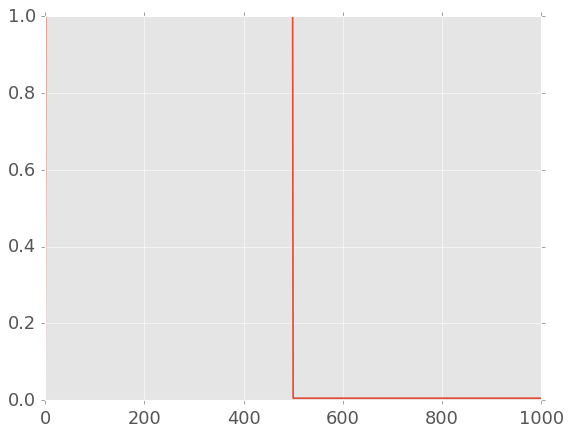

In [446]:
plt.plot(np.array(training_sims[-1].wireVoltage.T[b_training[-num_source_training:]]).T)

In [447]:
#find on switches
onSwitches=np.where(training_sims[-1].junctionSwitch[500,:])[0]

In [448]:
list(set(testing_list) - (set(testing_list) - set(training_list)))

[2, 4, 6, 8, 9]

In [449]:
nontargetElectrodes=list(set(testing_list) - set(training_list))
targetElectrodes=list(set(testing_list) - (set(testing_list) - set(training_list)))
inputElectrodes=targetElectrodes[-num_source_training:]
targetElectrodes=targetElectrodes[:-num_source_training]#remove source electrodes

In [450]:
training_sims

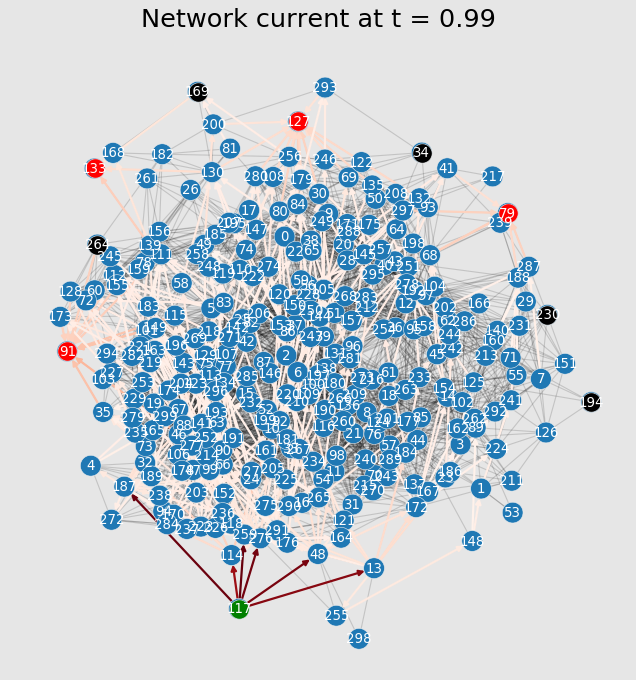

In [451]:
#Visualise Training Electrode Positions
draw_graph(training_sims[-1], time = 0.99, figsize=(10,10),colorbar=True)
G = nx.from_numpy_array(training_sims[-1].connectivity.adj_matrix)
pos=nx.kamada_kawai_layout(G)
#highlight input, target and output nodes:
nx.draw_networkx_nodes(G,pos=pos,nodelist=list(b_testing[targetElectrodes]),edgecolors=None)
nx.draw_networkx_nodes(G,pos=pos,nodelist=list(b_testing[nontargetElectrodes]),node_color='k',edgecolors=None)
nx.draw_networkx_nodes(G,pos=pos,nodelist=list(b_testing[inputElectrodes]),node_color='g',edgecolors=None)

In [452]:
#Draw Conductance Plots after Training

In [453]:
def getWeightedGraph(sims,network,edgeList,numWires):#, this_TimeStamp = 0):
#     edgeList = network['edge_list']
    adjMat = np.zeros((numWires, numWires))
#     set_trace()
    adjMat[edgeList[:,0], edgeList[:,1]] = sims.junctionConductance[-1]#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
    adjMat[edgeList[:,1], edgeList[:,0]] = sims.junctionConductance[-1]#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
    WeightedGraph = nx.from_numpy_array(adjMat)
    WeightedGraph=nx.DiGraph.to_undirected(WeightedGraph)
    
    return WeightedGraph

In [454]:
sim=training_sims[-1]
network=sim.connectivity.adj_matrix #use sample network to show functional graph
sources=sim.sources
drains=sim.drains
OGgraph=G
pos=nx.kamada_kawai_layout(OGgraph)
numWires=G.number_of_nodes()
sim.junctionResistance=1/sim.junctionConductance
edgeList=np.array(list(G.edges()))
#         subGraph=getOnGraph(sim,network,edgeList,numWires)
weightedSubGraph_Training=getWeightedGraph(sim,network,edgeList,numWires)

In [455]:
G2=weightedSubGraph_Training
edges=G2.edges()
weights1=([G2[u][v]['weight'] for u,v in edges])

In [456]:
maxWeights=np.max(weights1)
minWeights=np.min(weights1)

[]

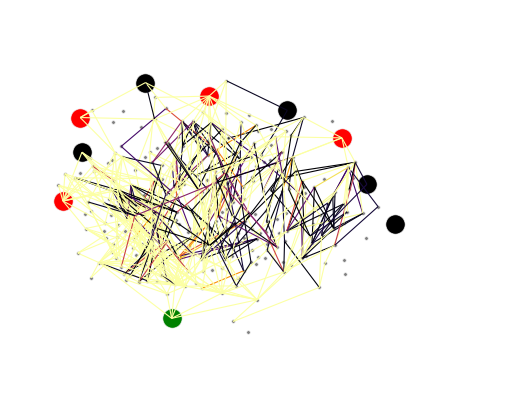

In [457]:
import matplotlib.colors as clrs

plt.figure()
ax=plt.gca()

G2=weightedSubGraph_Training
edge_weights=nx.get_edge_attributes(G2,'weight')
G2.remove_edges_from((e for e, w in edge_weights.items() if w <1e-6)) 
edges=G2.edges()
weights=[G2[u][v]['weight'] for u,v in edges]

OGgraph=G
#draw OG graph
pos=nx.kamada_kawai_layout(OGgraph)
h=nx.draw_networkx_nodes(OGgraph,pos=pos,node_color='grey',node_size=10,ax=ax)
h.set_zorder(1)

h2=nx.draw_networkx_edges(G2,pos=pos,ax=ax,edge_color=weights,edge_cmap=plt.cm.inferno,edge_vmin=minWeights,edge_vmax=maxWeights)

if h2:
    h2.set_norm(clrs.SymLogNorm(10))
    h2.set_zorder(3)
nx.draw_networkx_nodes(G,pos=pos,nodelist=list(b_testing[targetElectrodes]),edgecolors=None)
nx.draw_networkx_nodes(G,pos=pos,nodelist=list(b_testing[nontargetElectrodes]),node_color='k',edgecolors=None)
nx.draw_networkx_nodes(G,pos=pos,nodelist=list(b_testing[inputElectrodes]),node_color='g',edgecolors=None)
ax.set_frame_on(False)

ax.set_yticks([])
ax.set_xticks([])

In [458]:
#TESTING STIMULUS:

#ALL DRAINS ACTIVE

#Drains: 
for i in range(num_drain_testing):
    testing_stimulus.append((stimulus__(biasType='Drain',TimeVector=np.arange(0,signal_time,dt))))

#Sources
for i in range(num_source_testing):
    testing_stimulus.append((stimulus__(biasType='DC',onAmp=onAmp_testing,TimeVector=np.arange(0,signal_time,dt),f=f)))

In [459]:
#Run Test
resting_state=[]
for i in range(numTesting):
    print("Testing " + str(i+1))
    #Run test by feeding in the network states after training epochs  
    testing_sims[i]=runSim(connectivity, start_state=training_state[-1], stimulus=testing_stimulus, contactMode='preSet', electrodes=b_testing,T=signal_time, onAmp=onAmp_testing, dt=dt, f=f, findFirst=False,collapse=True)
    testing_state[i]=getJunctionState(testing_sims[i])
#     print("Rest " + str(i+1))
    #After we test, we want to let the network rest for 30 seconds before running more training epochs later
#     resting_sims[i]=(runSim(connectivity, start_state=testing_state[-1], stimulus=resting_stimulus, contactMode='preSet', electrodes=b_training,T=rest_between_training, onAmp=onAmp_training, dt=dt, f=f, findFirst=False,collapse=True))
#     resting_state.append(getJunctionState(resting_sims[i]))

Testing 1


In [431]:
# #PLOT TRAINING CURVE:
# # plt.plot(training_sims[0].electrodeCurrent[:,0:3])
# plt.plot(np.vstack((training_sims[-1].electrodeCurrent[:,0:3],testing_sims[0].electrodeCurrent[:,[0,2,4]])))
# plt.figure()
# plt.plot(testing_sims[0].electrodeCurrent[:,[0,2,4]])
# plt.plot(testing_sims[0].electrodeCurrent[:,[1,3,5,6,7,8]])


In [432]:
# print(training_list)
# print(testing_list)
# print(boolTargets)
# print(b_training)
# print(b_testing)

In [460]:
def drains_assign(testing_sims,training_sims,b_training,b_testing,num_drain_training,drainAndSourceTargets):

    #Compare training current output of target drains (open) with testing current output of target drains (open)
    drain_training={'Target':[None]*num_drain_training, 'Non-Target':[None]*(num_drain_testing-num_drain_training)}
    drain_testing={'Target':[None]*num_drain_training, 'Non-Target':[None]*(num_drain_testing-num_drain_training)}

    if num_drain_training == 3:
        #Target Drains: 
        temp=b_testing[drainAndSourceTargets]
        drain_training['Target'][0]=wireCurrentTimeSeries(training_sims[-1], temp[0])
        drain_training['Target'][1]=wireCurrentTimeSeries(training_sims[-1], temp[1])
        drain_training['Target'][2]=wireCurrentTimeSeries(training_sims[-1], temp[2])

        drain_testing['Target'][0]=wireCurrentTimeSeries(testing_sims[-1], temp[0])
        drain_testing['Target'][1]=wireCurrentTimeSeries(testing_sims[-1], temp[1])
        drain_testing['Target'][2]=wireCurrentTimeSeries(testing_sims[-1], temp[2])

        #Compare training current output of non-target drains (closed) with testing current output of non-target drains (open)
        #Non-Target Drains: 
        temp2=b_testing[~drainAndSourceTargets]
        drain_training['Non-Target'][0]=wireCurrentTimeSeries(training_sims[-1], temp2[0])
        drain_training['Non-Target'][1]=wireCurrentTimeSeries(training_sims[-1], temp2[1])
        drain_training['Non-Target'][2]=wireCurrentTimeSeries(training_sims[-1], temp2[2])
        drain_training['Non-Target'][3]=wireCurrentTimeSeries(training_sims[-1], temp2[3])
        drain_training['Non-Target'][4]=wireCurrentTimeSeries(training_sims[-1], temp2[4])
        drain_training['Non-Target'][5]=wireCurrentTimeSeries(training_sims[-1], temp2[5])

        drain_testing['Non-Target'][0]=wireCurrentTimeSeries(testing_sims[-1], temp2[0])
        drain_testing['Non-Target'][1]=wireCurrentTimeSeries(testing_sims[-1], temp2[1])
        drain_testing['Non-Target'][2]=wireCurrentTimeSeries(testing_sims[-1], temp2[2])
        drain_testing['Non-Target'][3]=wireCurrentTimeSeries(testing_sims[-1], temp2[3])
        drain_testing['Non-Target'][4]=wireCurrentTimeSeries(testing_sims[-1], temp2[4])
        drain_testing['Non-Target'][5]=wireCurrentTimeSeries(testing_sims[-1], temp2[5])
        
    elif num_drain_training == 4:
        #Target Drains: 
        temp=b_testing[drainAndSourceTargets]
        drain_training['Target'][0]=wireCurrentTimeSeries(training_sims[-1], temp[0])
        drain_training['Target'][1]=wireCurrentTimeSeries(training_sims[-1], temp[1])
        drain_training['Target'][2]=wireCurrentTimeSeries(training_sims[-1], temp[2])
        drain_training['Target'][3]=wireCurrentTimeSeries(training_sims[-1], temp[3])
        
        drain_testing['Target'][0]=wireCurrentTimeSeries(testing_sims[-1], temp[0])
        drain_testing['Target'][1]=wireCurrentTimeSeries(testing_sims[-1], temp[1])
        drain_testing['Target'][2]=wireCurrentTimeSeries(testing_sims[-1], temp[2])
        drain_testing['Target'][3]=wireCurrentTimeSeries(testing_sims[-1], temp[3])

        #Compare training current output of non-target drains (closed) with testing current output of non-target drains (open)
        #Non-Target Drains: 
        temp2=b_testing[~drainAndSourceTargets]
        drain_training['Non-Target'][0]=wireCurrentTimeSeries(training_sims[-1], temp2[0])
        drain_training['Non-Target'][1]=wireCurrentTimeSeries(training_sims[-1], temp2[1])
        drain_training['Non-Target'][2]=wireCurrentTimeSeries(training_sims[-1], temp2[2])
        drain_training['Non-Target'][3]=wireCurrentTimeSeries(training_sims[-1], temp2[3])
        drain_training['Non-Target'][4]=wireCurrentTimeSeries(training_sims[-1], temp2[4])

        drain_testing['Non-Target'][0]=wireCurrentTimeSeries(testing_sims[-1], temp2[0])
        drain_testing['Non-Target'][1]=wireCurrentTimeSeries(testing_sims[-1], temp2[1])
        drain_testing['Non-Target'][2]=wireCurrentTimeSeries(testing_sims[-1], temp2[2])
        drain_testing['Non-Target'][3]=wireCurrentTimeSeries(testing_sims[-1], temp2[3])
        drain_testing['Non-Target'][4]=wireCurrentTimeSeries(testing_sims[-1], temp2[4])

    return drain_training,drain_testing

In [461]:
drainAndSourceTargets

array([False, False,  True, False,  True, False,  True, False,  True,
       False])

In [462]:
#Assign Data to Target and Non-Target
drain_training,drain_testing=drains_assign(testing_sims,training_sims,b_training,b_testing,num_drain_training,drainAndSourceTargets)

In [477]:
lhs.shape

(500, 301)

In [475]:
#Linear Regression:
from edamame.core.simSettings import stimulus__

target = boolTargets
repeats=50
nodesList=np.array(list(G.nodes()))

wireVoltage = testing_sims[-1].wireVoltage
T, N = wireVoltage.shape
output = dict()
accuracy = np.zeros(repeats)
weight = np.zeros((repeats, len(nodesList)+1))
result = np.zeros((repeats, T))

for i in range(repeats):
    lhs = np.hstack((np.ones((T, 1)), wireVoltage[:,nodesList]))
    weight[i,:] = np.linalg.lstsq(lhs, target, rcond = None)[0]
    result[i,:] = np.dot(lhs, weight[i,:])
    accuracy[i] = 1-getRNMSE(result[i,:], target)

output['weight'] = np.mean(weight, axis = 0)
output['result'] = np.mean(result, axis = 0)
output['accuracy'] = np.mean(accuracy)
output['target'] = target

LinAlgError: Incompatible dimensions

In [463]:
#CROSS CORRELATION:

sclistTarget=[None]*len(drain_testing['Target'])
sclistNonTarget=[None]*len(drain_testing['Non-Target'])

# DOT PRODUCT CROSS CORRLATION
for i in range(len(drain_testing['Target'])): #for number of training sessions
    a=drain_training['Target'][i][:500].reshape(-1)
    b=drain_testing['Target'][i].reshape(-1)
    #take the first 500 seconds of training signal and compare to testing signal
    sclistTarget[i]=np.dot(a,b) 
        
for i in range(len(drain_testing['Non-Target'])): #for number of training sessions
    a=drain_training['Non-Target'][i][:500].reshape(-1)
    b=drain_testing['Non-Target'][i].reshape(-1)
    #take the first 500 seconds of training signal and compare to testing signal
    sclistNonTarget[i]=np.dot(a,b)
    
#Adrian Cross Correlation    
# I_ave=[None]*numSessions
# I_tar=[None]*numSessions
# sclist[0],I_tar[0],I_ave[0]=cross_correlation_adrian(testing_sims[-1],boolTargets)

[]

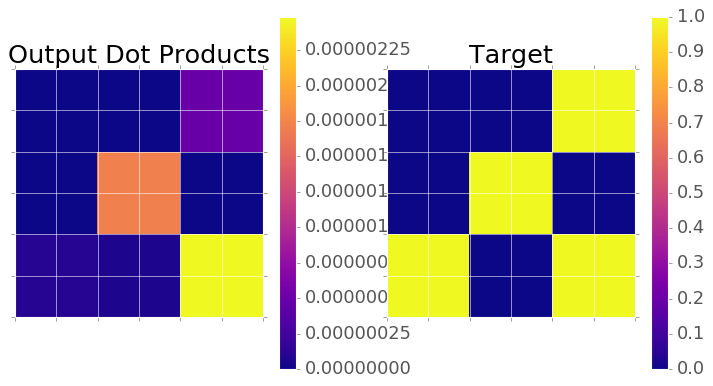

In [466]:
grid = np.zeros(9)

gridTarget=[i for i, x in enumerate(boolTargets) if x] #find target electrodes
gridNonTarget=[i for i, x in enumerate(boolTargets) if ~x] #find non-target electrodes

grid[gridTarget] = sclistTarget #find crosscorrelation values of target electrodes
grid[gridNonTarget] = sclistNonTarget #find crosscorrelation values of non-target electrodes
    
grid=(grid.reshape(3,3))

#Plot cross-correlation grid: 
fig1 = plt.figure(figsize=(11,11))
ax1=fig1.add_subplot(1, 2, 1)
ax1.title.set_text('Output Dot Products')
plt.imshow(grid,interpolation='none',cmap='plasma')#,norm=clrs.LogNorm())
plt.colorbar(shrink=0.5)
# plt.axis('off')

ax2=fig1.add_subplot(1, 2, 2)
ax2.title.set_text('Target')
plt.imshow((boolTargets.reshape(3,3)).astype(int),interpolation='none',cmap='plasma')
plt.colorbar(shrink=0.5)


#Remove Tick Labels
fig1.axes[0].get_xaxis().set_ticklabels([])
fig1.axes[0].get_yaxis().set_ticklabels([])
fig1.axes[2].get_xaxis().set_ticklabels([])
fig1.axes[2].get_yaxis().set_ticklabels([])
# plt.text(-4,4,'Cross-Correlation = ' + str(grid[0]))

In [586]:
# Linear Regression Model:

In [569]:
drain_outputs=np.concatenate((np.array(drain_testing['Target'][:]).reshape(4,500),np.array(drain_testing['Non-Target'][:]).reshape(5,500)))

In [578]:
drain_outputs.T

array([[3.32487094e-07, 6.26138561e-07, 1.37899853e-07, ...,
        6.40971781e-09, 6.56577182e-08, 2.57099110e-07],
       [1.32979915e-05, 2.50436937e-05, 5.51660646e-06, ...,
        2.55606451e-07, 2.62418435e-06, 1.02841696e-05],
       [1.32988225e-05, 2.50428282e-05, 5.51636488e-06, ...,
        2.56579385e-07, 2.62477599e-06, 1.02840472e-05],
       ...,
       [1.26455689e-05, 2.39518517e-05, 5.25363462e-06, ...,
        1.27595895e-06, 3.03419477e-06, 1.00944454e-05],
       [1.26437566e-05, 2.39494858e-05, 5.25291246e-06, ...,
        1.27696503e-06, 3.03594418e-06, 1.00940516e-05],
       [1.26419518e-05, 2.39471265e-05, 5.25219075e-06, ...,
        1.27796525e-06, 3.03769628e-06, 1.00936591e-05]])

In [575]:
target=np.zeros([9,500])

In [579]:
for i in training_list[:-2]:
    target[i]=[3e-05]*500

(0, 3e-05)

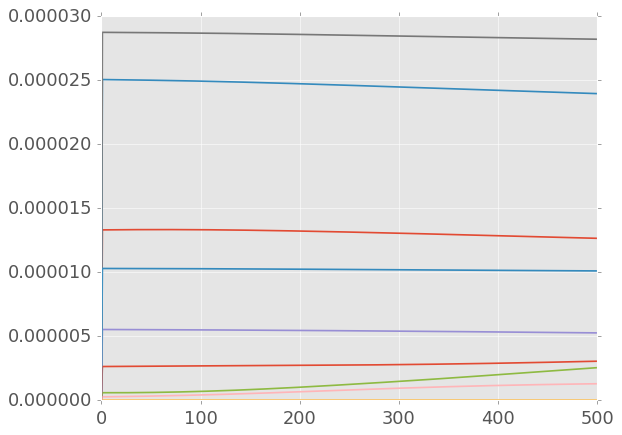

In [545]:
plt.plot(np.concatenate((np.array(drain_testing['Target'][:]).reshape(4,500),np.array(drain_testing['Non-Target'][:]).reshape(5,500))).T)
plt.ylim([0,0.00003])

In [726]:
from edamame.core.simSettings import stimulus__

target = target
nodesList=[0,1,2,3,4,5,6,7,8]
# wireVoltage = network.wireVoltage    
T, N = drain_outputs.shape
output = dict()
accuracy = np.zeros(repeats)
weight = np.zeros((repeats, len(nodesList)+1))
result = np.zeros((repeats, T))

for i in range(repeats):
    lhs = np.hstack((np.ones((T, 1)),drain_outputs[nodesList,:].T))
    weight[i,:] = np.linalg.lstsq(lhs, target.T, rcond = None)[0]
    result[i,:] = np.dot(lhs, weight[i,:])
    accuracy[i] = 1-getRNMSE(result[i,:], target)

output['weight'] = np.mean(weight, axis = 0)
output['result'] = np.mean(result, axis = 0)
output['accuracy'] = np.mean(accuracy)
output['target'] = target

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [717]:
np.linalg.lstsq(lhs, target.T, rcond = None)[0]

array([[ 0.00000000e+00,  0.00000000e+00,  3.00000000e-05,
         0.00000000e+00,  3.00000000e-05,  0.00000000e+00,
         3.00000000e-05,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -5.27594988e-11,
         0.00000000e+00, -5.27594988e-11,  0.00000000e+00,
        -5.27594988e-11,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -7.39964559e-11,
         0.00000000e+00, -7.39964559e-11,  0.00000000e+00,
        -7.39964559e-11,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  8.95009391e-10,
         0.00000000e+00,  8.95009391e-10,  0.00000000e+00,
         8.95009391e-10,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -2.64540888e-10,
         0.00000000e+00, -2.64540888e-10,  0.00000000e+00,
        -2.64540888e-10,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -8.16744352e-09,
         0.00000000e+00, -8.16744352e-09,  0.000000

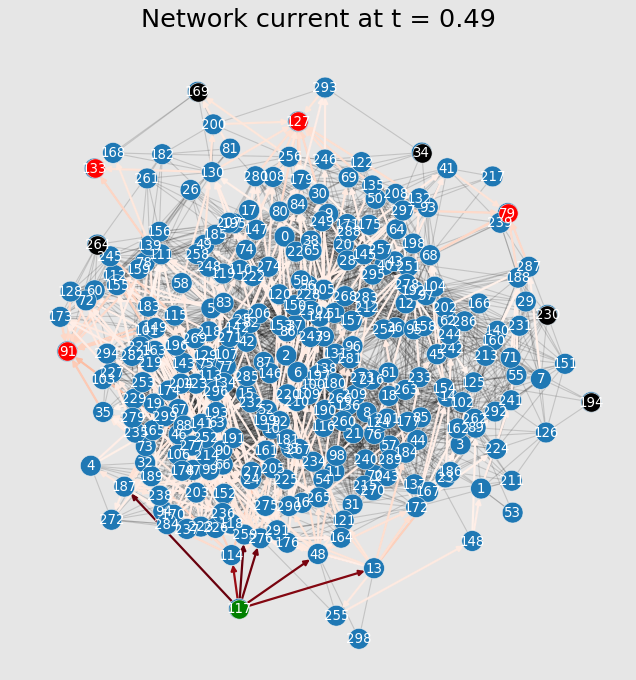

In [470]:
#Visualise Training Electrode Positions
draw_graph(testing_sims[-1], time = 0.49, figsize=(10,10),colorbar=True)
G = nx.from_numpy_array(training_sims[-1].connectivity.adj_matrix)
pos=nx.kamada_kawai_layout(G)
#highlight input, target and output nodes:
nx.draw_networkx_nodes(G,pos=pos,nodelist=list(b_testing[targetElectrodes]),edgecolors=None)
nx.draw_networkx_nodes(G,pos=pos,nodelist=list(b_testing[nontargetElectrodes]),node_color='k',edgecolors=None)
nx.draw_networkx_nodes(G,pos=pos,nodelist=list(b_testing[inputElectrodes]),node_color='g',edgecolors=None)

In [ ]:
### ADD REINFORCEMENT HERE - REWARD/PUNISH BASED ON HOW CLOSE TO TARGET

# Training 2

In [277]:
#Change Signal after rest to repeat training + testing
b_testing_2=np.array([194, 230, 79, 34, 127, 169, 133, 264, 128, 4,117, 148])#edamame.core.getBoundaryPairing(connectivity,9)
b_training_2=b_testing_2[:]

pattern_type=4 # CHANGE PATTERN HERE

# Open Electrodes for training 
if pattern_type == 1:
    training_list=[0,2,4,9,10,11] #drains, then sources
elif pattern_type == 2:
    training_list=[4,7,8,9,10,11] #drains, then sources
elif pattern_type == 3:
    training_list=[0,4,7,8,9,10,11] #drains, then sources
elif pattern_type == 4:
    training_list=[2,4,6,8,9,10,11] #drains, then sources
    

# Open Electrodes for testing
# testing_list=[0,1,2,3,4,5,6,7,8,9,11,13]#Drains then sources 
testing_list=[0,1,2,3,4,5,6,7,8,9,10,11]#Drains then sources

num_source_training=3
num_source_testing=num_source_training
num_drain_testing=len(testing_list)-num_source_testing

b_testing_2=b_testing_2[testing_list]
b_training_2=b_training_2[training_list]

training_stimulus_2 = []
testing_stimulus_2 = []
training_sims_2=[None]*numTraining
testing_sims_2=[None]*numTesting
resting_stimulus_2=[]

#TRAINING STIMULUS
# ONLY DRAINS WITH CORRESPONDING STIMULUS SOURCE ARE ACTIVE
#Drains: 
for i in range(num_drain_training):
    #DRAIN WITHOUT REST
    training_stimulus_2.append((stimulus__(biasType='Drain',TimeVector=np.arange(0,run_time,dt))))
    resting_stimulus_2.append((stimulus__(biasType='Drain',TimeVector=np.arange(0,rest_between_training,dt))))
    #Can we do reinforcement training by changing amplitude of drains that we don't want involved?
    
#Sources
for i in range(num_source_training):
    #SOURCE WITHOUT REST
    training_stimulus_2.append((stimulus__(biasType='DC',onAmp=onAmp_training,TimeVector=np.arange(0,signal_time,dt),f=f)))
    
    #ADD REST AT THE END
    training_stimulus_2[(num_drain_training)+i].signal=np.concatenate([np.array(stimulus__(biasType='DC',onAmp=onAmp_training,TimeVector=np.arange(0,signal_time,dt),f=f).signal), np.array([0.005]*int(rest_time/dt))]) 
    
#CONVERT TO BOOLEAN FOR TARGET PATTERN:

if pattern_type == 1:
    boolTargets=np.array([onAmp_training,0,onAmp_training,0,onAmp_training,0,0,0,0]).astype(bool)

elif pattern_type == 2:
    boolTargets=np.array([0,0,0,0,onAmp_training,0,0,onAmp_training,onAmp_training]).astype(bool)

elif pattern_type == 3:
    boolTargets=np.array([onAmp_training,0,0,0,onAmp_training,0,0,onAmp_training,onAmp_training]).astype(bool)

drainAndSourceTargets_2=np.hstack((boolTargets,np.array([0,0,0]).astype(bool)))


#TESTING STIMULUS:

#Drains: 
for i in range(num_drain_testing):
    testing_stimulus_2.append((stimulus__(biasType='Drain',TimeVector=np.arange(0,signal_time,dt))))

#Sources
for i in range(num_source_testing):
    testing_stimulus_2.append((stimulus__(biasType='DC',onAmp=onAmp_testing,TimeVector=np.arange(0,signal_time,dt),f=f)))

In [279]:
#Repeat Training + Testing:

#Training:
for i in range(numTraining):#,numTraining*numSessions):
    print("Training " + str(i+1))
    #PUT IN REST FOR SECOND TRAINING
    training_sims_2[i]=(runSim(connectivity, start_state=resting_state[-1], stimulus=training_stimulus_2, contactMode='preSet', electrodes=b_training_2,T=run_time, onAmp=onAmp_training, dt=dt, f=f, findFirst=False,collapse=True))
    training_state.append(getJunctionState(training_sims_2[i]))
#Testing
for i in range(numTesting):
    print("Testing " + str(i+1))
    testing_sims_2[i]=(runSim(connectivity, start_state=training_state[-1], stimulus=testing_stimulus_2, contactMode='preSet', electrodes=b_testing_2,T=signal_time, onAmp=onAmp_testing, dt=dt, f=f, findFirst=False,collapse=True))
    
    testing_state.append(getJunctionState(testing_sims_2[i]))

2020-09-14 14:05:55,877:WARNING:Number of electrodes and stimulus not consistent. Current setup has 7 electrodes!


Training 1


SystemExit: 

In [272]:
# sclist[1],I_tar[1],I_ave[1]=cross_correlation(testing_sims[-1])
drain_training2,drain_testing2=drains_assign(testing_sims_2,training_sims_2,b_training_2,b_testing_2,num_drain_training,drainAndSourceTargets_2)

sclistTarget=[None]*len(drain_testing2['Target'])
sclistNonTarget=[None]*len(drain_testing2['Non-Target'])

# DOT PRODUCT CROSS CORRLATION
for i in range(len(drain_testing2['Target'])):
    a=drain_training2['Target'][i][:500].reshape(-1)
    b=drain_testing2['Target'][i].reshape(-1)
    #take the first 500 seconds of training signal and compare to testing signal
    sclistTarget[i]=np.dot(a,b) 
        
for i in range(len(drain_testing2['Non-Target'])):
    a=drain_training2['Non-Target'][i][:500].reshape(-1)
    b=drain_testing2['Non-Target'][i].reshape(-1)
    #take the first 500 seconds of training signal and compare to testing signal
    sclistNonTarget[i]=np.dot(a,b)

In [273]:
sclistTarget

[4.0298288113874595e-06, 5.156265945520601e-06, 4.769056856907686e-06]

In [274]:
sclistNonTarget

[9.490091612605146e-09,
 4.939683728997059e-12,
 5.536035783724629e-14,
 1.7450632369568724e-08,
 3.997016970432277e-14,
 3.383246242557624e-15]

[]

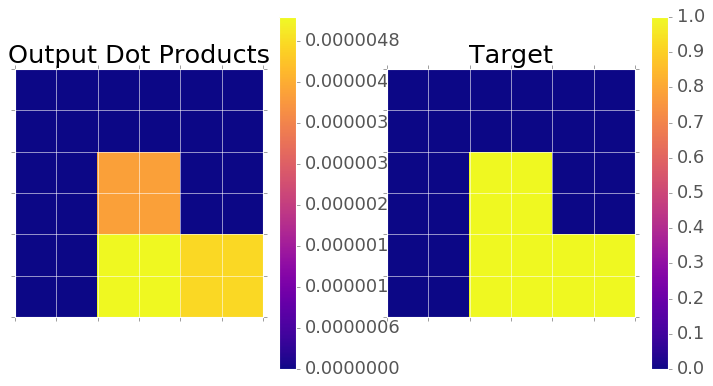

In [275]:
grid = np.zeros(9)

gridTarget=[i for i, x in enumerate(boolTargets) if x] #find target electrodes
gridNonTarget=[i for i, x in enumerate(boolTargets) if ~x] #find non-target electrodes

grid[gridTarget] = sclistTarget #find crosscorrelation values of target electrodes
grid[gridNonTarget] = sclistNonTarget #find crosscorrelation values of non-target electrodes
    
grid=(grid.reshape(3,3))

#Plot cross-correlation grid: 
fig1 = plt.figure(figsize=(11,11))
ax1=fig1.add_subplot(1, 2, 1)
ax1.title.set_text('Output Dot Products')
plt.imshow(grid,interpolation='none',cmap='plasma')
plt.colorbar(shrink=0.5)
# plt.axis('off')

ax2=fig1.add_subplot(1, 2, 2)
ax2.title.set_text('Target')
plt.imshow((boolTargets.reshape(3,3)).astype(int),interpolation='none',cmap='plasma')
plt.colorbar(shrink=0.5)


#Remove Tick Labels
fig1.axes[0].get_xaxis().set_ticklabels([])
fig1.axes[0].get_yaxis().set_ticklabels([])
fig1.axes[2].get_xaxis().set_ticklabels([])
fig1.axes[2].get_yaxis().set_ticklabels([])
# plt.text(-4,4,'Cross-Correlation = ' + str(grid[0]))

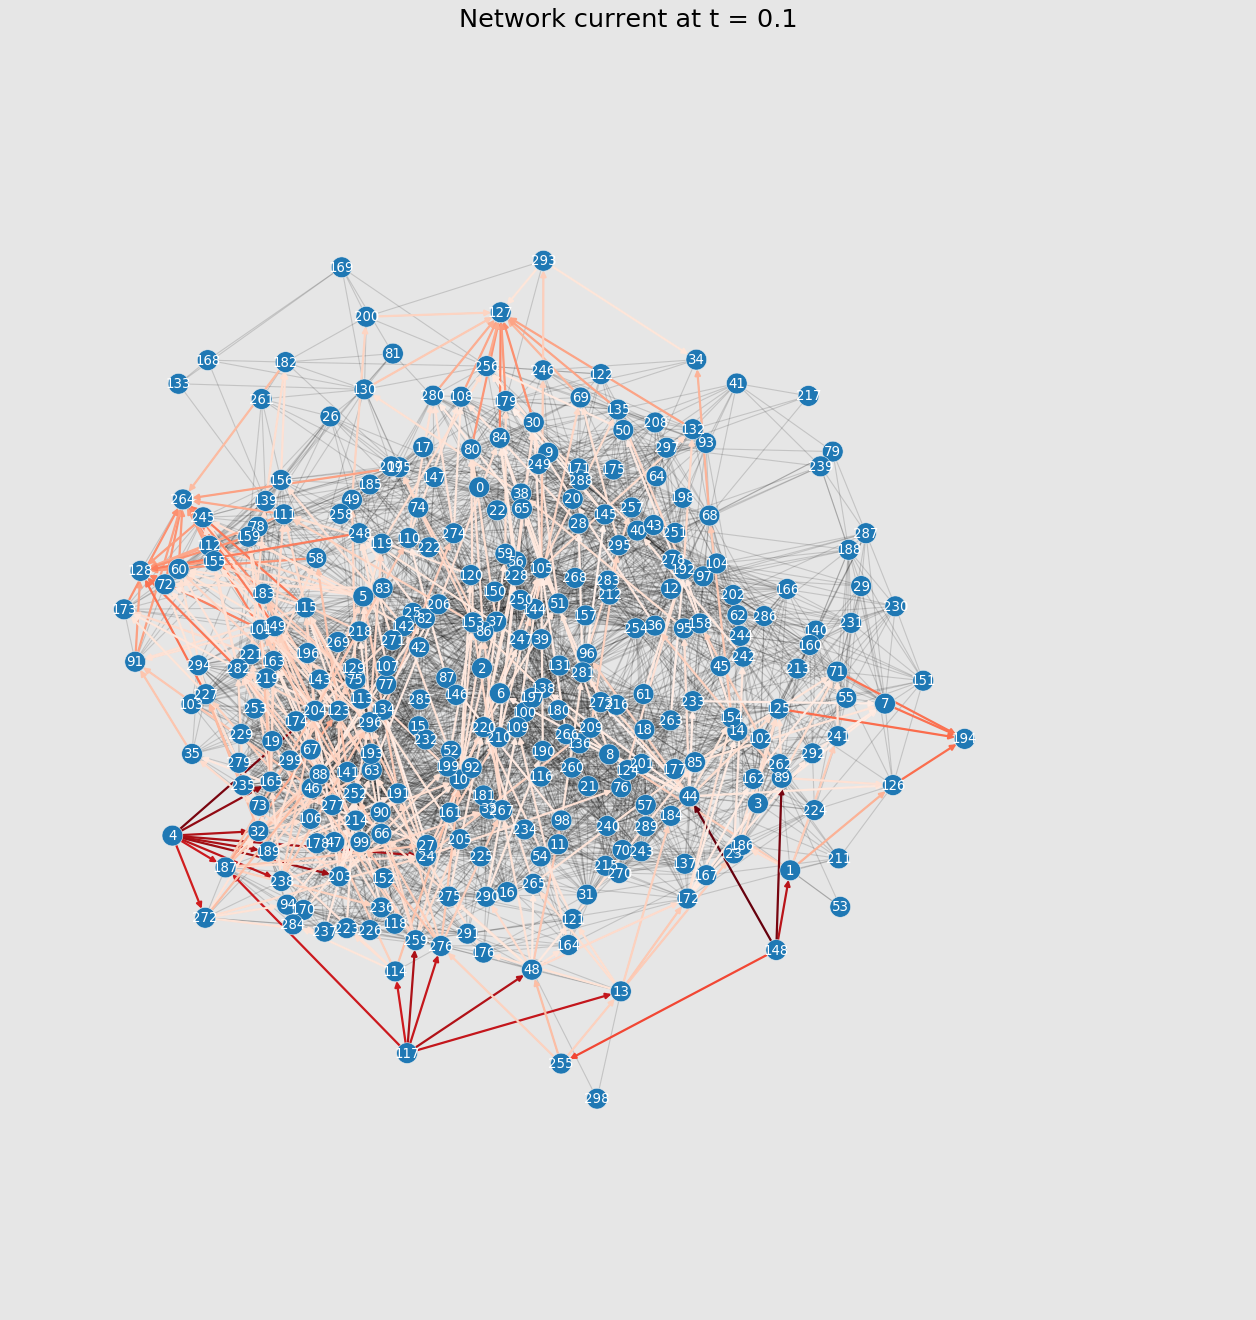

In [204]:
#Visualise Testing Electrode Positions
draw_graph(testing_sims[1], time = 0.1, figsize=(20,20),colorbar=True)

In [26]:

# fig1 = plt.figure(figsize=(11,11))
# fig1.add_subplot(1, 2, 1)
# plt.imshow(I_tar[1].astype(int).reshape(3,3),cmap='plasma')
# plt.colorbar(shrink=0.5)
# # plt.axis('off')

# fig1.add_subplot(1, 2, 2)
# plt.imshow(I_ave[1].reshape(3,3),cmap='plasma')
# plt.colorbar(shrink=0.5)
# #Remove Tick Labels
# fig1.axes[0].get_xaxis().set_ticklabels([])
# fig1.axes[0].get_yaxis().set_ticklabels([])
# fig1.axes[2].get_xaxis().set_ticklabels([])
# fig1.axes[2].get_yaxis().set_ticklabels([])
# plt.text(-4,4,'Cross-Correlation = ' + str(sclist[1]))

# # im1 = axes[0].imshow(I_tar.astype(int).reshape(3,3),cmap='plasma')
# # im2 = axes[1].imshow(I_ave.reshape(3,3),cmap='plasma')

In [17]:
# Cross Correlation:
def cross_correlation_adrian(testing_sims,boolTargets):
    avecurr=[]
    I_ave=[]
    I_tar=[]
    un=[]
    dos=[]
    newcurr=[]
    sclist=[]
    avecurr=np.mean(testing_sims.electrodeCurrent[:,0:9],0) #find the average current for each training simulation for each drain electrode

    # #sclist=zeros(1,length(avecurr));
#     for i in range(len(avecurr)):
    I_ave=avecurr #average current at the ith channel
    I_tar=boolTargets #logical of which channels were used;

    un=(I_ave-np.mean(I_ave))
    dos=(I_tar-np.mean(I_tar))

    u=np.dot(un,dos)
    d=np.sqrt(np.sum(un**2)*np.sum(dos**2))

    sclist=u/d 
    return sclist, I_tar,I_ave